In [1]:
from climpyrical.gridding import find_nearest_index, find_element_wise_nearest_pos, scale_model_obs
from climpyrical.mask import gen_raster_mask_from_vector, gen_upper_archipelago_mask, stratify_coords
import climpyrical.spytialProcess as sp
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import krigit_north, rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from rpy2.robjects.packages import importr
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import NearestNDInterpolator
from sklearn.neighbors import NearestNeighbors
import pickle

from tqdm import tqdm
import dask.array as da
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import matplotlib


from pykrige.ok import OrdinaryKriging

importr("fields")


%load_ext autoreload
%autoreload 2

In [2]:
# parameter cell
# these currently have default values but are configurable when 
# executing this notebook with papermill

station_dv = "RL50 (kPa)"
station_input_path = resource_filename("climpyrical", "data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv")
name = "RL50"
processed_model_output_path = resource_filename("climpyrical", "data/results/intermediate/preprocessed_models/default.nc")
output_reconstruction_path = resource_filename("climpyrical", f"data/results/datasets/RL50_reconstructed.nc")
df_path_write = resource_filename('climpyrical', f'data/results/intermediate/preprocessed_stations/RL50_processed_stations.csv')

In [3]:
dsold_max = 28.15999984741211

mask_path = resource_filename(
    'climpyrical',
    'data/masks/canada_mask_rp.nc'
)

north_mask_path = resource_filename(
    'climpyrical',
    'data/masks/canada_mask_north_rp.nc'
)

ds = read_data(processed_model_output_path)
(dv, ) = ds.data_vars
mask = read_data(mask_path)['mask'].values
northern_mask = read_data(north_mask_path)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

In [4]:
df = pd.read_csv(df_path_write, index_col=False)
df.head(5)

,irlat,irlon,id,lon,lat,elev (m),SL50 (kPa),RL50 (kPa),rlat,rlon,model_values,ratio
0,558,1009,6038.0,-82.95560,42.27560,190.0,1.0,0.402,-4.286849,10.373390,0.285755,1.179944
1,559,1009,6037.0,-82.93330,42.33330,188.0,1.2,0.484,-4.227125,10.379271,0.286351,1.417673
2,576,1017,5880.0,-82.30470,42.99220,181.0,1.5,0.389,-3.494586,10.713492,0.286172,1.140122
3,577,1048,123.0,-80.42906,42.77439,214.0,1.4,0.470,-3.434479,12.106219,0.320984,1.228128
4,579,1046,5921.0,-80.55000,42.86670,232.0,1.5,0.587,-3.362845,11.999925,0.317087,1.552705


separate stations into beyond and within the model domain

In [5]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

# Krig the station only values in the north

In [6]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])

In [7]:
# choose starting value
# model_vals = ds[dv].values[df.ilocy.values, df.ilocx.values]
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

print(best_tol)

0.8387427753361661


In [8]:
np.seterr(divide='ignore', invalid='ignore')
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

 64%|██████▎   | 262/411 [04:16<02:52,  1.16s/it]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/local/lib/R/site-library’ contains no packages

R[write to console]: Timing stopped at: 0.027 0

In [30]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = ratio_field[nanmask]
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])

combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

In [31]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 0.10195435952925318 
UAA_station_mean 0.081 
Combined 0.09147717976462659


In [32]:
if 'degC' in station_dv and not 'degC-day' in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    ratio_field_filled -= K
    df[station_dv] -= K

In [33]:
ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon)

In [34]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [35]:
ds_recon.to_netcdf(output_reconstruction_path, 'w')

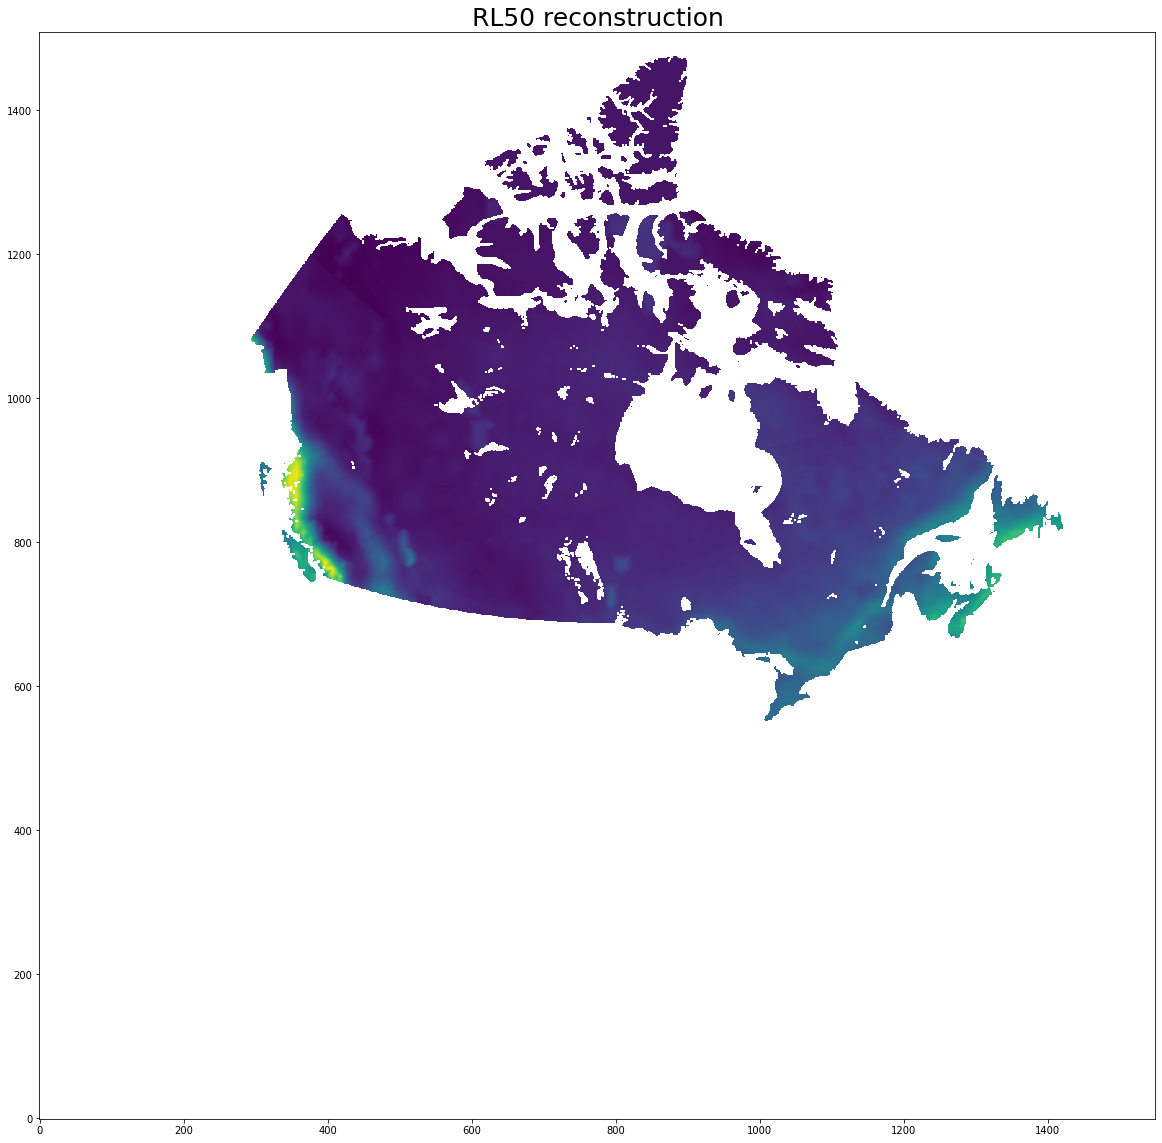

In [36]:
plt.figure(figsize=(20, 20))
plt.title(f"{name} reconstruction", fontsize=25)
plt.imshow(ds_recon[dv], origin='lower')